# Google Analytics Customer Revenue Prediction


#### Objective of the competition:
We are challenged to analyze google merchandise store customer dataset to predict revenue per customer.
    

In [2]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [3]:
import pandas as pd
pd.__version__

'0.23.4'

* fullVisitorId unique user id
* channelGrouping channel via which user came to store
* date date of the visit
* device specifications for devide used to access store
* geoNetwork information about geography of user
* sessionId unique id of the visit
* socialEngagementType engagement type 
* totals aggregate values across sessions
* trafficSource traffic source from which the session originated
* visitId id for the session,this is only unique to user, for complete unique ID, use combination of fullVisitorId and visitId
* visitNumber the session number of this user, if this is the first session, then set to 1
* visitStartTime timestamp, expressed as POSIX time


In [4]:
def load_df(csv_path='./data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
#         column_as_df = df[column].apply(lambda x: pd.Series(x))
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [5]:
%%time
train_orig = load_df()

Loaded train.csv. Shape: (903653, 55)
CPU times: user 2min 42s, sys: 3.85 s, total: 2min 46s
Wall time: 2min 50s


In [6]:
%%time
train_df = load_df()

Loaded train.csv. Shape: (903653, 55)
CPU times: user 3min 45s, sys: 3.51 s, total: 3min 49s
Wall time: 3min 49s


In [7]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

In [8]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [9]:
%%time
test_df = load_df('./data/test.csv')

Loaded test.csv. Shape: (804684, 53)
CPU times: user 2min 38s, sys: 2.3 s, total: 2min 40s
Wall time: 2min 48s


### Target Varable Exploration
Sum up transaction revenue at user level and take a log and then do a scatter plot

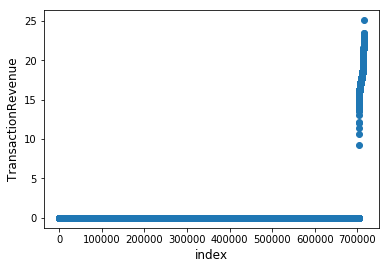

In [10]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype('float')
gdf = train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()

plt.figure()
plt.scatter(range(gdf.shape[0]),
           np.sort( np.log1p(gdf['totals.transactionRevenue'].values))
           )
plt.xlabel('index',fontsize=12)
plt.ylabel('TransactionRevenue',fontsize=12)
plt.show()

In [11]:
nzi = pd.notnull(train_df['totals.transactionRevenue']).sum()
nzr = (gdf['totals.transactionRevenue']>0).sum()
print(" Number of instance in train set with non-zero:",nzi,"and ratio is:",nzi/train_df.shape[0])
print(" Number of unique user in train with non-zero:", nzr,"and ratio is:",nzr/gdf.shape[0])

 Number of instance in train set with non-zero: 11515 and ratio is: 0.0127427231470487
 Number of unique user in train with non-zero: 9996 and ratio is: 0.013996726255903731


### number of visitor and common visitor

In [12]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  714167  out of rows :  903653
Number of unique visitors in test set :  617242  out of rows :  804684
Number of common visitors in train and test set :  7679


In [13]:
# Remove constant values
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False) == 1]

In [14]:
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [15]:
for c in const_cols:
    train_df.drop(c,axis=1,inplace=True)
    test_df.drop(c,axis=1,inplace=True)
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.campaignCode', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source'],
      dty

In [16]:
# get device information
def horizontal_bar_chart(cnt_srs,color):
    trace = go.Bar(
        x = cnt_srs.values[::-1],
        y = cnt_srs.index[::-1],
        showlegend=False,
        orientation = 'h',
        marker = dict(color = color,),
    )
    return trace
    

In [17]:
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count_of_non_zero_revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count',ascending=False)
trace1 = horizontal_bar_chart(cnt_srs['count'].head(10),'rgba(50,171,96,0.6)')
trace2 = horizontal_bar_chart(cnt_srs['count_of_non_zero_revenue'].head(10),'rgba(50,171,96,0.6)')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(10),'rgba(50,171,96,0.6)')
cnt_srs
# cnt_srs['count_of_non_zero_revenue'].head(10)

,count,count_of_non_zero_revenue,mean
device.browser,,,
Chrome,620364,10353,1.335946e+08
Safari,182245,780,6.717626e+07
Firefox,37069,191,4.676247e+08
Internet Explorer,19375,109,7.573899e+07
Edge,10205,58,1.117753e+08
Android Webview,7865,6,1.914167e+07
Safari (in-app),6850,12,1.281417e+07
Opera Mini,6139,0,NaN
Opera,5643,5,4.307000e+07


In [18]:
## device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count_of_non_zero_revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count',ascending=False)

In [19]:
# cnt_srs
my_color = 'rgba(71,58,131,0.8)'
trace4 = horizontal_bar_chart(cnt_srs['count'].head(10),my_color)
trace5 = horizontal_bar_chart(cnt_srs['count_of_non_zero_revenue'].head(10),my_color)
trace6 = horizontal_bar_chart(cnt_srs['mean'].head(10),my_color)
cnt_srs

,count,count_of_non_zero_revenue,mean
device.deviceCategory,,,
desktop,664479,10495,1.411019e+08
mobile,208725,852,5.843405e+07
tablet,30449,168,5.607940e+07


In [20]:
## Operating System
tag = 'device.operatingSystem'
my_color = 'rgba(246, 78, 139, 0.6)'
cnt_srs = train_df.groupby(tag)['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count_of_non_zero_revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count',ascending=False)

trace7 = horizontal_bar_chart(cnt_srs['count'].head(10),my_color)
trace8 = horizontal_bar_chart(cnt_srs['count_of_non_zero_revenue'].head(10),my_color)
trace9 = horizontal_bar_chart(cnt_srs['mean'].head(10),my_color)
cnt_srs

,count,count_of_non_zero_revenue,mean
device.operatingSystem,,,
Windows,350072,2309,1.720713e+08
Macintosh,253938,6426,1.332673e+08
Android,123892,467,7.781859e+07
iOS,107665,536,4.135616e+07
Linux,35034,782,5.615141e+07
Chrome OS,26337,994,1.850480e+08
(not set),4695,0,NaN
Windows Phone,1216,1,2.640000e+07
Samsung,280,0,NaN


In [21]:
# create subplot
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04,
                         subplot_titles=['Device Browser - Count', 'Device Browser - non-zero Revenue Count','Device Browser - Mean Revenue',
                                         'Device Category - Count', 'Device Category - non-zero Revenue Count','Device Category - Mean Revenue',
                                         'Device OS - Count','Device OS -non-zero Revenue Count','Device OS- Mean Revenue']
                                              )
fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,2)
fig.append_trace(trace3,1,3)
fig.append_trace(trace4,2,1)
fig.append_trace(trace5,2,2)
fig.append_trace(trace6,2,3)
fig.append_trace(trace7,3,1)
fig.append_trace(trace8,3,2)
fig.append_trace(trace9,3,3)
fig['layout'].update(height=1000,width=1000,paper_bgcolor='rgb(233,233,233)',title='Device Plots')
py.iplot(fig,filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [22]:
# Date Exploration
import datetime 
def scatter_plot(cnt_srs,color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace
train_df.head(3).date

0    20160902
1    20160902
2    20160902
Name: date, dtype: int64

In [23]:
train_df['date'] = train_df['date'].apply(lambda x: datetime.date( int(str(x)[:4]), int(str(x)[4:6]),
                                                                 int(str(x)[6:8])))
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
# cnt_srs

In [24]:
trace1 = scatter_plot(cnt_srs['count'],'red')
trace2 = scatter_plot(cnt_srs['count of non-zero revenue'],'blue')
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')


This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [25]:
# lets check the date distribution of test set
# test_df['date'] = test_df['date'].apply(lambda x: datetime.date( int(str(x)[:4]), int(str(x)[5:7]),
#                                                                  int(str(x)[8:10])))
cnt_srs = test_df.groupby('date')['device.isMobile'].agg(['size', 'count'])
cnt_srs.columns = ["count",'isMobile']
cnt_srs
trace1 = scatter_plot(cnt_srs['count'],'red')
# trace2 = scatter_plot(cnt_srs['count of non-zero revenue'],'blue')
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
# fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')


This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [26]:
# Continent information
# Continent
cnt_srs = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [27]:
# Continent
cnt_srs = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [28]:
# Page views
cnt_srs = train_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



### Baseline Model

In [29]:
# print colums that exist in train but not in test
print("variable in train not in test : ",set(train_df.columns).difference(set(test_df.columns)))

variable in train not in test :  {'trafficSource.campaignCode', 'totals.transactionRevenue'}


In [30]:
cols_to_drop = ['sessionId']
train_df = train_df.drop(cols_to_drop + ['trafficSource.campaignCode'],axis=1)
test_df = test_df.drop(cols_to_drop,axis=1)

In [31]:
# train_df.columns
# test_df.columns

In [32]:
# create development and validation splits based on time to build the model
# We use the last two months as validation sample
# Impute 0 for missing target values

train_df['totals.transactionRevenue'].fillna(0,inplace=True)
train_y = train_df['totals.transactionRevenue'].values
train_id = train_df['fullVisitorId'].values
test_id = test_df['fullVisitorId'].values



In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null object
fullVisitorId                                   903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null object
geoNetwork.city                                 903653 non-null object
geoNetwork.continent                            903653 non-null object
geoNetwork.country                        

In [34]:
# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']

In [35]:
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform( list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform( list( test_df[col].values.astype('str')))
    
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']  
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)
    


channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [36]:
dev_df = train_df[ train_df['date'] <= datetime.date(2017,5,31)]
val_df = train_df[ train_df['date'] > datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df['totals.transactionRevenue'].values)
val_y = np.log1p(val_df['totals.transactionRevenue'].values)

dev_x = dev_df[cat_cols + num_cols]
val_x = val_df[cat_cols + num_cols]
test_x = test_df[cat_cols + num_cols]


In [37]:
# custom function to run light gbm model
def run_lgb(train_x,train_y, val_x,val_y,test_x):
    params = {
        'objective':"regression",
        'metric':"rmse",
        "num_leaves":30,
        "min_child_samples":100,
        "learning_rate":0.1,
        "bagging_fraction":0.7,
        "feature_fraction":0.5,
        "bagging_frequency":5,
        "bagging_seed":2018,
        'verbosity':-1
    }
    
    
    lgtrain = lgb.Dataset(train_x,label=train_y)
    lgval = lgb.Dataset(val_x,label=val_y)
    model = lgb.train(params,lgtrain,1000,valid_sets=[lgval],
                     early_stopping_rounds=100,verbose_eval=100)
    pred_test_y = model.predict(test_x,num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_x,num_iteration=model.best_iteration)
    return pred_test_y,model,pred_val_y


In [38]:
pred_test,model, pred_val = run_lgb(dev_x,dev_y,val_x,val_y,test_x)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69586
[200]	valid_0's rmse: 1.69126
[300]	valid_0's rmse: 1.69175
Early stopping, best iteration is:
[254]	valid_0's rmse: 1.69087


In [39]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)

In [40]:
# val_pred_df

In [41]:
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.709925685736863


In [42]:
sub_df = pd.DataFrame( {'fullVisitorId':test_id} )
pred_test[pred_test < 0] = 0
sub_df['PredictedLogRevenue'] = np.expm1(pred_test)
sub_df = sub_df.groupby('fullVisitorId')['PredictedLogRevenue'].sum().reset_index()
sub_df.columns = ['fullVisitorId','PredictedLogRevenue']

In [43]:
sub_df['PredictedLogRevenue'] = np.log1p(sub_df['PredictedLogRevenue'])
sub_df.to_csv('baseline_lgb.csv',index=False)

In [44]:
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.516011
1,0000049363351866189,0.000000
2,0000053049821714864,0.007906
3,0000059488412965267,0.048398
4,0000085840370633780,0.011108


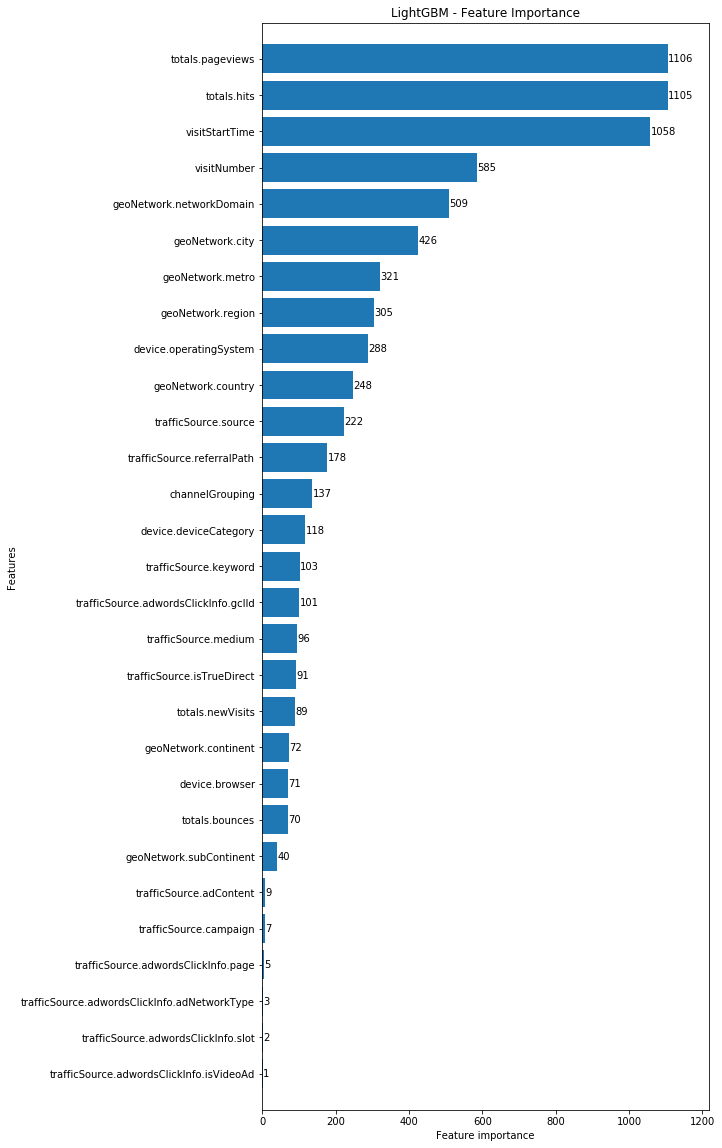

In [45]:
# Check feature importance
fig,ax = plt.subplots(figsize=(8,20))
lgb.plot_importance(model,max_num_features=50,height=0.8,ax=ax)
ax.grid(False)
plt.title('LightGBM - Feature Importance')
plt.show()

#### Submitted to Kaggle and get a public score of: 1.4453

In [46]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.deviceCategory',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'],
      dtype='object')

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                                 903653 non-null int64
date                                            903653 non-null object
fullVisitorId                                   903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null float64
visitStartTime                                  903653 non-null float64
device.browser                                  903653 non-null int64
device.deviceCategory                           903653 non-null int64
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null int64
geoNetwork.city                                 903653 non-null int64
geoNetwork.continent                            903653 non-null int64
geoNetwork.country                          

#### My questions
#### Part2
1. Is there any missing data
2. check to see if there is outlier 
3. What is the distribution of each feature
4. For numerical features, should I convert them to categorial?
5. For label features, convert to categorial?
6. Check for correlation between features

In [48]:
## First of all, lets try to understand the meaning of each feature
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                                 903653 non-null int64
date                                            903653 non-null object
fullVisitorId                                   903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null float64
visitStartTime                                  903653 non-null float64
device.browser                                  903653 non-null int64
device.deviceCategory                           903653 non-null int64
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null int64
geoNetwork.city                                 903653 non-null int64
geoNetwork.continent                            903653 non-null int64
geoNetwork.country                          

fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
channelGrouping - The channel via which the user came to the Store.
date - The date on which the user visited the Store.
device - The specifications for the device used to access the Store.
geoNetwork - This section contains information about the geography of the user.
sessionId - A unique identifier for this visit to the store.
socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
totals - This section contains aggregate values across the session.
trafficSource - This section contains information about the Traffic Source from which the session originated.
visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
visitNumber - The session number for this user. If this is the first session, then this is set to 1.
visitStartTime - The timestamp (expressed as POSIX time).

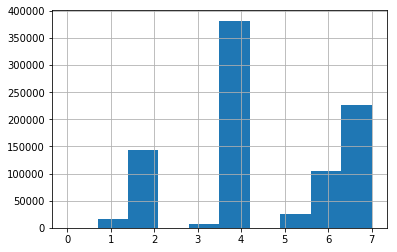

In [49]:
train_df['channelGrouping'].hist()

In [50]:
# ## Play with oraginal train to see the actuall data
# for col in train_orig.columns:
#     print("-----------------> %s" % col)
#     print(train_orig[col].unique())

In [51]:
train_df['logRevenue'] = np.log1p(train_df['totals.transactionRevenue'])

In [52]:
for feature in train_df.columns:
    print('------------------------> %s ' % feature)
    print(train_df[[feature,'logRevenue']].groupby(feature,as_index=False).mean())

------------------------> channelGrouping 
   channelGrouping  logRevenue
0                0    0.134309
1                1    0.009405
2                2    0.257472
3                3    0.417089
4                4    0.158370
5                5    0.325533
6                6    0.907610
7                7    0.007979
------------------------> date 
           date  logRevenue
0    2016-08-01    0.354300
1    2016-08-02    0.141498
2    2016-08-03    0.000000
3    2016-08-04    0.092381
4    2016-08-05    0.273975
5    2016-08-06    0.110306
6    2016-08-07    0.176800
7    2016-08-08    0.218055
8    2016-08-09    0.266918
9    2016-08-10    0.299009
10   2016-08-11    0.307676
11   2016-08-12    0.480062
12   2016-08-13    0.161683
13   2016-08-14    0.232552
14   2016-08-15    0.380892
15   2016-08-16    0.371951
16   2016-08-17    0.261104
17   2016-08-18    0.285797
18   2016-08-19    0.365677
19   2016-08-20    0.230494
20   2016-08-21    0.240644
21   2016-08-22    0.402591
22

        visitStartTime  logRevenue
0         1.470035e+09         0.0
1         1.470035e+09         0.0
2         1.470035e+09         0.0
3         1.470035e+09         0.0
4         1.470035e+09         0.0
5         1.470035e+09         0.0
6         1.470035e+09         0.0
7         1.470035e+09         0.0
8         1.470036e+09         0.0
9         1.470036e+09         0.0
10        1.470036e+09         0.0
11        1.470036e+09         0.0
12        1.470036e+09         0.0
13        1.470036e+09         0.0
14        1.470036e+09         0.0
15        1.470036e+09         0.0
16        1.470036e+09         0.0
17        1.470036e+09         0.0
18        1.470037e+09         0.0
19        1.470037e+09         0.0
20        1.470037e+09         0.0
21        1.470037e+09         0.0
22        1.470037e+09         0.0
23        1.470037e+09         0.0
24        1.470037e+09         0.0
25        1.470037e+09         0.0
26        1.470037e+09         0.0
27        1.470037e+

     geoNetwork.region  logRevenue
0                    0    0.030074
1                    1    0.000000
2                    2    0.000000
3                    3    0.000000
4                    5    0.000000
5                    7    0.000000
6                   10    0.000000
7                   11    0.148259
8                   12    0.000000
9                   13    0.000000
10                  14    0.000000
11                  15    0.000000
12                  16    0.000000
13                  18    0.000000
14                  19    0.000000
15                  20    0.000000
16                  22    0.000000
17                  23    0.000000
18                  24    0.000000
19                  25    0.457476
20                  26    0.000000
21                  27    0.000000
22                  28    0.000000
23                  29    0.024563
24                  30    0.000000
25                  31    0.000000
26                  33    0.000000
27                  

       trafficSource.adwordsClickInfo.gclId  logRevenue
0                                         1    0.000000
1                                        10    0.000000
2                                        16    0.000000
3                                        21    0.000000
4                                        23    0.000000
5                                        24    0.000000
6                                        29    0.000000
7                                        33    0.000000
8                                        42    0.000000
9                                        58    0.000000
10                                       60    0.000000
11                                       72    0.000000
12                                       76    0.000000
13                                       78    0.000000
14                                       88    0.000000
15                                       95    0.000000
16                                      103    0

ValueError: Grouper for 'logRevenue' not 1-dimensional

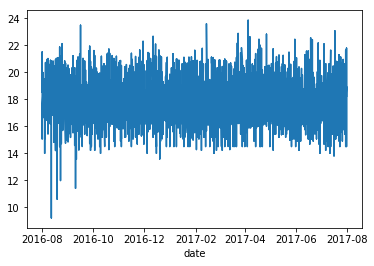

In [53]:
train_df[train_df['logRevenue']!=0].set_index('date')['logRevenue'].plot()

In [ ]:
# Do a feature graphics analysis of all features
# Virtualize the correlation into figures
features = train_df.columns[:5]
target = 'totals.transactionRevenue'
fignum = features.shape[0]
fignum 
fig, axes = plt.subplots(fignum,1,figsize=(5,10))
plt.subplots_adjust(hspace=1.5)

for index,feature in enumerate(features):
    sns.barplot(x=feature,y=target,data=train_df,ax=axes[index])
plt.show()

In [54]:
train_orig.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [55]:
train_orig['geoNetwork.networkDomain']

0               ttnet.com.tr
1                dodo.net.au
2            unknown.unknown
3            unknown.unknown
4            unknown.unknown
5              fastwebnet.it
6            unknown.unknown
7             bigpond.net.au
8                    spar.at
9                  chello.nl
10        airtelbroadband.in
11                wanadoo.fr
12           unknown.unknown
13           unknown.unknown
14        cabotelecom.com.br
15           unknown.unknown
16             igmholding.nl
17                 nerim.net
18           unknown.unknown
19        phonevision.com.ar
20                  tpnet.pl
21          live-servers.net
22           unknown.unknown
23             asianet.co.th
24                cbn.net.id
25                hafele.com
26            coltfrance.com
27              broadband.hu
28           unknown.unknown
29           unknown.unknown
                 ...        
903623       unknown.unknown
903624       unknown.unknown
903625           verizon.net
903626        

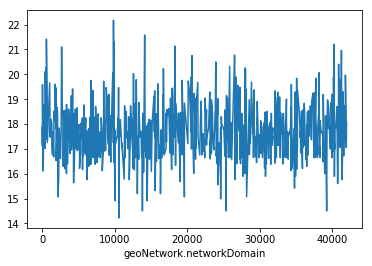

In [64]:
# does geoNetwork.networkDomain matter?
train_df[train_df['logRevenue']!=0].groupby('geoNetwork.networkDomain')['logRevenue'].mean().plot()

In [ ]:
# get neworkDomain frequency

domain_freq = train_df.groupby('geoNetwork.networkDomain')['logRevenue'].count().copy()
# domain_freq.plot()
print(domain_freq.shape)
fdf = pd.DataFrame(columns=['DomainId','f','f_bin'])
fdf.DomainId = domain_freq.index
fdf.f = np.log1p(domain_freq.values)
# fdf.f = (domain_freq.values)
# fdf = fdf.sort_values(by=['f'])
fdf
bin_ranges = [0,1,2,3,4,5,6,7,8,9,10,15]
# bin_ranges = [0,10,50,1000000]
bin_label = [1,2,3,4,5,6,7,8,9,10,11]
# bin_label = [1,2,3]
# fdf.plot(x='DomainId',y='f')
fdf['f_bin'] = pd.cut(fdf.f,bins=bin_ranges,labels=bin_label)
# fdf['f_bin'] = pd.qcut(fdf.f,11,labels=bin_label)
# fdf.f_bin.hist()
# fdf

# fdf.set_index(keys='DomainId',inplace=True)
# fdf.drop(['f'],inplace=True,axis=1)
# print(fdf)
# str(fdf.f_bin.values)
# mapper = {fdf.DomainId.values:fdf.f_bin.values}


# fdf.info()
def domain_func(domain_code):
    return fdf[fdf.DomainId==domain_code]['f_bin']
#     return 1

# %time domain_func(0)
# %time
import dask.dataframe as dd
ddf = dd.from_pands(train_df,npartitions=4)


train_df['networkDomain'] = ddf['geoNetwork.networkDomain'].apply(lambda x: domain_func(x))
train_df['networkDomain']

In [ ]:
what we learned, some networkDomain have way more occurance then others,
there are many that have less then 10 occurance, what we can do is to convert 
those with less then 10 occurance into category 0 -> unknown

In [278]:
pd.qcut(range(5), 4)

[(-0.001, 1.0], (-0.001, 1.0], (1.0, 2.0], (2.0, 3.0], (3.0, 4.0]]
Categories (4, interval[float64]): [(-0.001, 1.0] < (1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0]]

In [253]:
# fil = ( train_df['geoNetwork.networkDomain'] < 10 )
# train_df[fil]['geoNetwork.networkDomain']

33        0
36        0
45        0
49        0
50        0
55        0
62        0
64        0
67        0
83        0
87        0
95        0
102       0
107       0
109       0
119       0
121       0
125       0
134       0
142       0
143       0
146       0
154       0
156       0
161       0
165       0
172       0
184       0
190       0
191       0
         ..
903504    0
903506    0
903510    0
903511    0
903517    0
903522    0
903525    0
903532    0
903535    0
903536    0
903544    0
903545    0
903547    0
903548    0
903553    0
903554    0
903565    0
903579    0
903582    0
903587    0
903603    0
903613    0
903619    0
903628    0
903631    0
903635    0
903636    0
903640    0
903642    0
903643    0
Name: geoNetwork.networkDomain, Length: 245834, dtype: int64

In [225]:
## Part2.1 check for missing data
print("hello")

hello


In [ ]:
## Part2 2 check each feature distribution and see if there is outlier

In [ ]:
## Part2. 3 is every feature convert to categorial?


In [ ]:
## Part2. 4 check for correlation between different features